In [1]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 3

import xarray as xr
import matplotlib.pyplot as plt
from helpers.computational_tools import *
import xesmf as xe
import gsw

from helpers.collection_of_experiments import CollectionOfExperiments

In [2]:
ds = CollectionOfExperiments.init_folder('/scratch/js15017/OM4_storage/CORE-AIF-runs', additional_subfolder='', Averaging_time=slice('1981', '2007'))

In [3]:
param = ds['unparameterized'].param

In [15]:
mask_domain = xr.where(np.isnan(ds['unparameterized'].ocean_annual_z.thetao.isel(time=-1)), np.nan,1.)

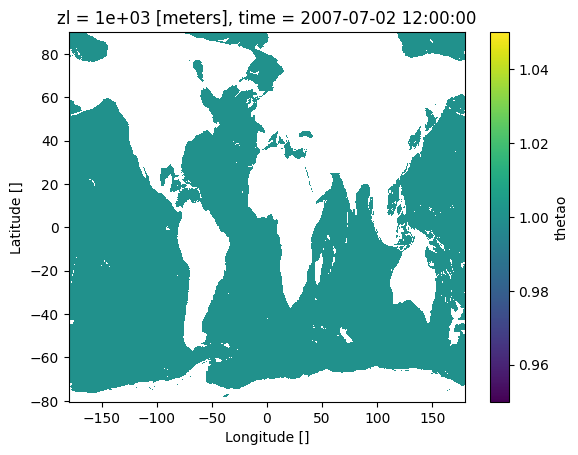

In [21]:
mask_domain[18].plot()

In [4]:
from cmip_basins import generate_basin_codes
basincodes = generate_basin_codes(param, lon='geolon', lat='geolat', mask='wet')

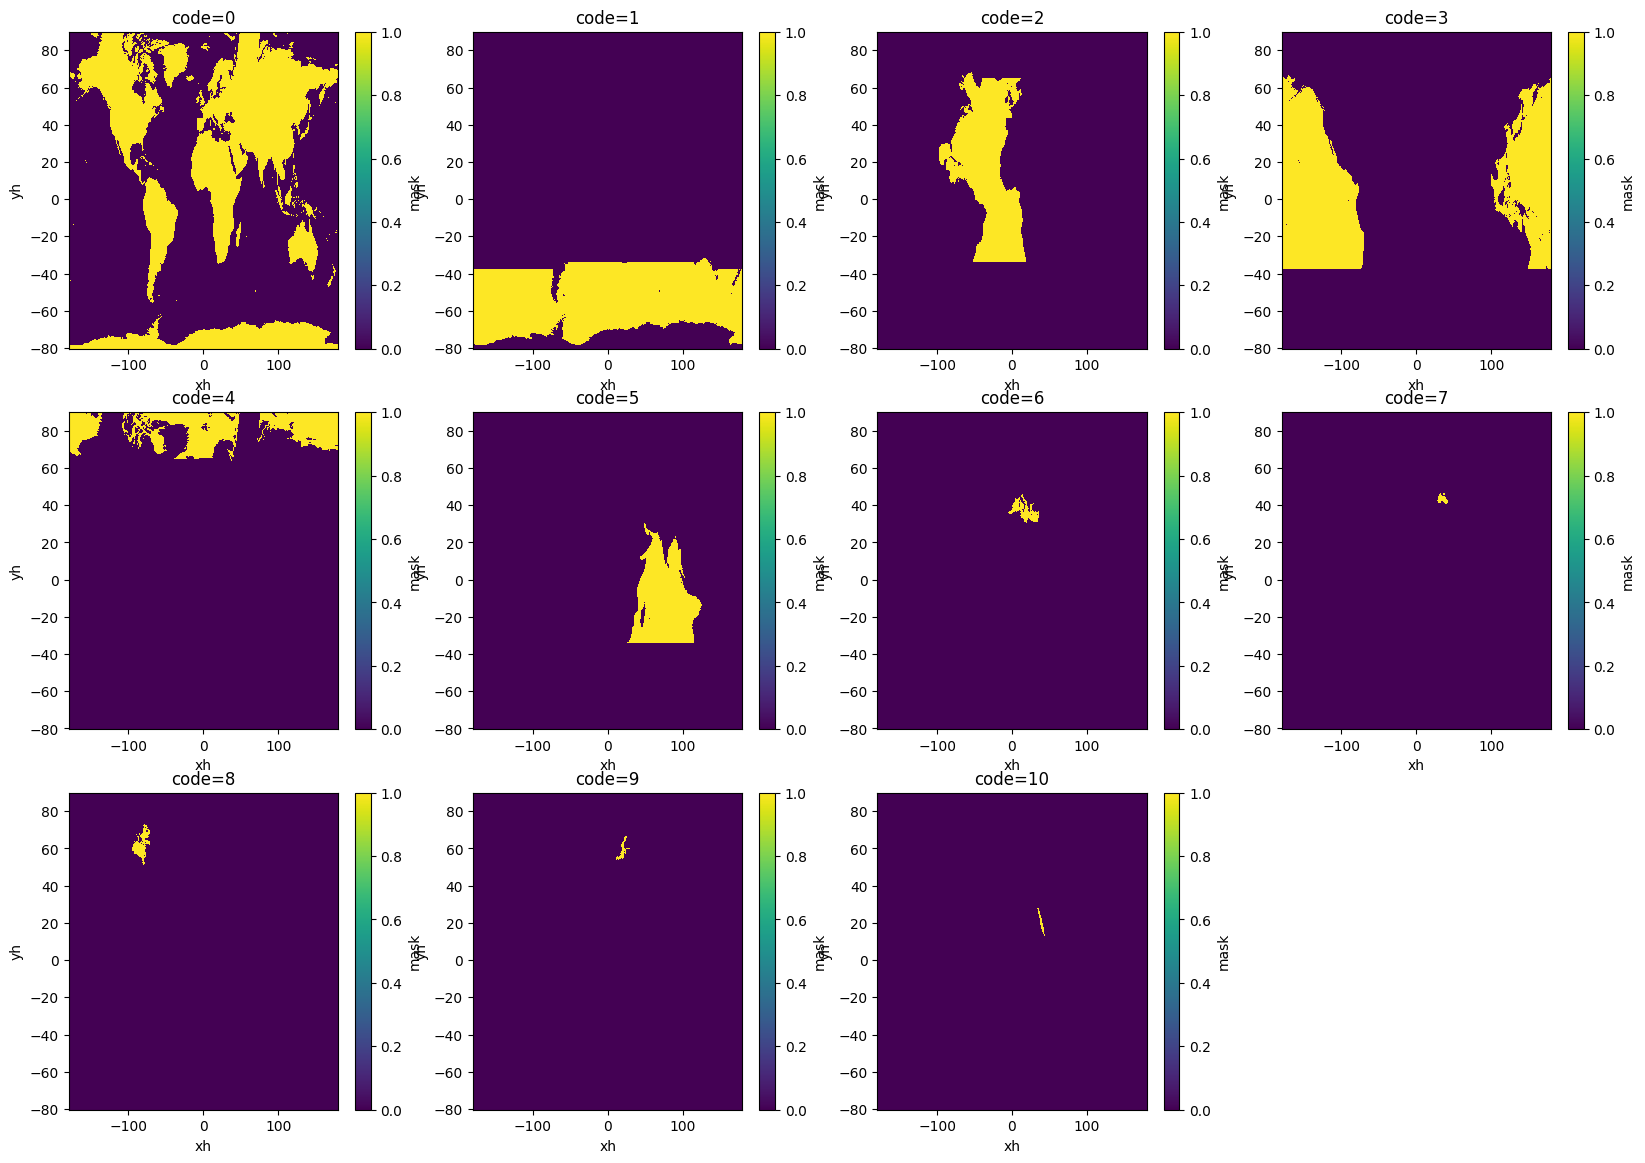

In [5]:
plt.figure(figsize=(20,14))
for code in range(11):
    plt.subplot(3,4,code+1)
    (code==basincodes).plot()
    plt.title(f'code={code}')

In [115]:
mask_simple = xr.where(basincodes.isin([1,2,3,5]),1.,np.nan)
# # Remove Arctic APE basin
mask_simple.loc[{'xh':slice(-11,30), 'yh':slice(59,70)}] = np.nan 

In [116]:
mask_simple = mask_simple.values + xr.zeros_like(param.areacello)

In [117]:
mask_simple = mask_simple * mask_domain[18]

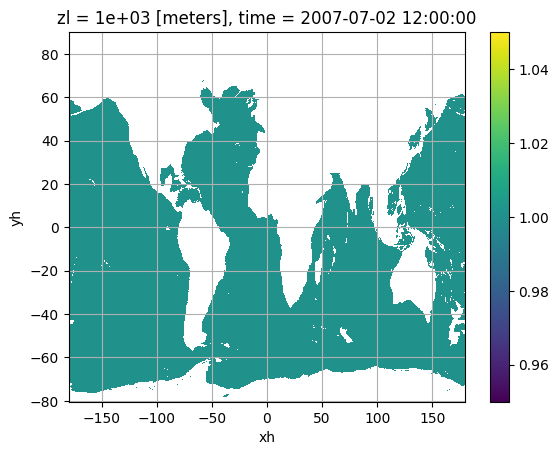

In [118]:
(mask_simple).plot()
plt.grid()

In [119]:
APE_ctrl = xr.open_dataset('APE_ctrl.nc').__xarray_dataarray_variable__

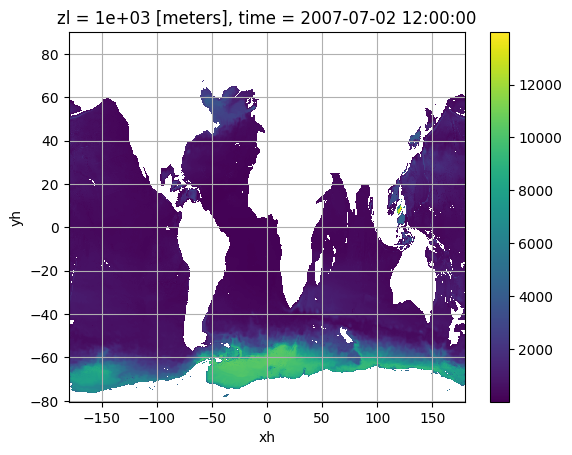

In [120]:
(mask_simple * APE_ctrl.sum('zi')).plot()
plt.grid()

In [121]:
T = (mask_simple * ds['unparameterized'].ocean_annual_z.thetao.isel(time=-1)).compute().transpose('zl',...)
S = (mask_simple * ds['unparameterized'].ocean_annual_z.so.isel(time=-1)).compute().transpose('zl',...)

In [122]:
mask_nan = xr.where(np.isnan(T),np.nan,1.)

In [123]:
dV = (param.areacello * ds['unparameterized'].dz * mask_nan).transpose('zl',...)

In [124]:
# There pressure in dbars is approximately the depth of the level, i.e. zl
rho_in_situ = gsw.density.rho(S, T, T.zl)

In [125]:
rho_sigma2 = gsw.density.sigma2(S,T)
rho_sigma0 = gsw.density.sigma0(S,T)

Text(0.5, 1.0, '')

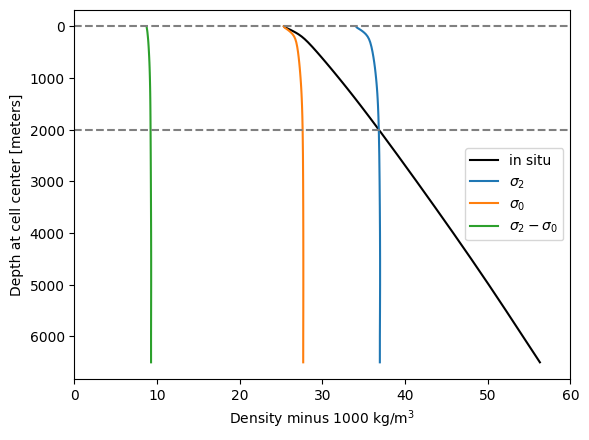

In [126]:
(rho_in_situ-1000).mean(['xh','yh']).plot(label='in situ', color='k', y='zl')
rho_sigma2.mean(['xh','yh']).plot(label='$\sigma_2$', y='zl')
rho_sigma0.mean(['xh','yh']).plot(label='$\sigma_0$', y='zl')
(rho_sigma2-rho_sigma0).mean(['xh','yh']).plot(label='$\sigma_2-\sigma_0$', y='zl')
plt.gca().invert_yaxis()
plt.xlabel('Density minus 1000 kg/m$^3$')
plt.legend()
plt.axhline(y=0,color='gray', ls='--')
plt.axhline(y=2000,color='gray', ls='--')
plt.xlim([0,60])
plt.title('')

# Sorting sigma2 potential density

In [127]:
def sort_xarray(_x,*_y):
    # Form 1D array
    x = _x.values.ravel()
    # Skip nans
    x = x[~np.isnan(x)]

    # Find sort indices
    sort_indices = np.argsort(x)
    x = x[sort_indices]
    out = [x]
    for y in _y:
        if not(np.array_equal(np.isnan(_x), np.isnan(y))):
            print('Check that NaNs are in the same places')
            return
        y = y.values.ravel()
        y = y[~np.isnan(y)]
        y = y[sort_indices]
        out.append(y)
    return out

In [128]:
rho_sigma2_sorted, dV_sorted, T_sorted, S_sorted = sort_xarray(rho_sigma2, dV, T, S)

In [129]:
# For simplicity (of indexing) we start our algorithm from the surface (i.e. light fluid)
rho_sigma2_sorted

array([25.55942668, 25.58266261, 25.78923356, ..., 37.5864833 ,
       37.58684036, 37.58686816])

In [130]:
dV_sorted

array([3.82707456e+09, 3.86195872e+09, 3.81561216e+09, ...,
       8.04675600e+09, 8.04675600e+09, 8.04675600e+09])

In [131]:
dV_sorted_cumsum = np.cumsum(dV_sorted)
dV_sorted_cumsum

array([3.82707456e+09, 7.68903328e+09, 1.15046454e+10, ...,
       1.38169803e+18, 1.38169803e+18, 1.38169804e+18])

In [132]:
dV_bins = np.pad(dV.sum(['xh','yh']).cumsum('zl').values,(1,0)) # Cumsum starting from the surface
dV_bins[-1] = dV_bins[-1] + 1e+18 # To make sure that all values correspond to some bin

In [133]:
print(dV_bins)
print(dV_bins.shape)

[0.00000000e+00 1.56718918e+15 4.70156753e+15 7.83594588e+15
 1.25375134e+16 1.95898647e+16 2.74258106e+16 3.52617565e+16
 4.30977024e+16 5.48516212e+16 7.05235129e+16 8.61954047e+16
 1.09703242e+17 1.41047026e+17 1.72390809e+17 2.03734593e+17
 2.35078376e+17 2.66422160e+17 2.97765944e+17 3.29109727e+17
 3.60341019e+17 3.91453263e+17 4.22443641e+17 4.53302263e+17
 5.07077282e+17 5.83313673e+17 6.96251375e+17 8.43387741e+17
 9.83888316e+17 1.11209367e+18 1.21996427e+18 1.30116346e+18
 1.35263266e+18 1.37606145e+18 1.38117526e+18 2.38169804e+18]
(36,)


In [134]:
# Bin fluid elements
bin_indices = []
for zi in range(len(dV_bins)-1):
    bin_indices.append(np.logical_and(dV_sorted_cumsum >= dV_bins[zi], dV_sorted_cumsum < dV_bins[zi+1]))

In [135]:
len(bin_indices)

35

In [137]:
# Find rho in situ of the reference state
rho_in_situ_ref = xr.zeros_like(T.zl)
rho_sigma2_ref = xr.zeros_like(T.zl)
rho_sigma2_ref_edges = xr.zeros_like(ds['unparameterized'].ocean_annual_z.z_i) # Edges of the binning algorithm
for zl in range(len(T.zl)):
    idx = bin_indices[zl]
    # Here we assume that fluid particles conserve not only their potential density,
    # but also potential temperature and salinity
    rho = gsw.density.rho(S_sorted[idx], T_sorted[idx], [float(T.zl[zl])] * idx.sum())
    # Here we compute mass of the layer, its volume, and redefine the in situ density as mass over volume
    rho_in_situ_ref[zl] = (rho * dV_sorted[idx]).sum() / (dV_sorted[idx]).sum()
    rho_sigma2_ref[zl] = (rho_sigma2_sorted[idx] * dV_sorted[idx]).sum() / (dV_sorted[idx]).sum()

rho_sigma2_ref_edges[0] = rho_sigma2_sorted[0]-1e-1 # -1e-1 so all grid points are for sure here
rho_sigma2_ref_edges[-1] = rho_sigma2_sorted[-1]+1e-1 # +1e-1 so all grid points are for sure here
for zi in range(1,len(rho_sigma2_ref_edges)-1):
    idx_upper = bin_indices[zi-1]
    idx_lower = bin_indices[zi]
    # Find the middle point between edges of the two sets
    rho_sigma2_ref_edges[zi] = (np.max(rho_sigma2_sorted[idx_upper]) + np.min(rho_sigma2_sorted[idx_lower])) * 0.5

In [138]:
rho_sigma2_ref

<xarray.DataArray 'zl' (zl: 35)> Size: 280B
array([29.83183607, 30.6154199 , 31.28271624, 32.07200158, 32.9465741 ,
       33.6107705 , 34.10629906, 34.46374689, 34.76963507, 35.05890065,
       35.28242502, 35.48903345, 35.68940248, 35.86887957, 36.01182929,
       36.13768461, 36.24642052, 36.33858009, 36.41878639, 36.48917266,
       36.54906274, 36.60893926, 36.64744933, 36.69564735, 36.74808796,
       36.79983642, 36.85234388, 36.89456312, 36.92490993, 36.94982511,
       36.98124318, 37.02454723, 37.0490871 , 37.05836668, 37.07829461])
Coordinates:
  * zl       (zl) float64 280B 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
    time     object 8B 2007-07-02 12:00:00
Attributes:
    long_name:       Depth at cell center
    units:           meters
    cartesian_axis:  Z
    positive:        down
    edges:           z_i

In [139]:
rho_sigma2_ref_edges

<xarray.DataArray 'z_i' (z_i: 36)> Size: 288B
array([25.45942668, 30.21088547, 30.95298461, 31.61555574, 32.49206399,
       33.30759817, 33.88263439, 34.30734832, 34.60643656, 34.90850133,
       35.18414731, 35.37710449, 35.58554768, 35.78112536, 35.94127947,
       36.07661368, 36.20044851, 36.29505099, 36.37504213, 36.45147631,
       36.51890131, 36.5778864 , 36.62451232, 36.67556251, 36.71224902,
       36.76947738, 36.83222769, 36.87577401, 36.90964259, 36.93600966,
       36.96533156, 37.00445028, 37.04433647, 37.05449878, 37.06426382,
       37.68686816])
Coordinates:
  * z_i      (z_i) float64 288B 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
Attributes:
    long_name:       Depth at interface
    units:           meters
    cartesian_axis:  Z
    positive:        down

In [140]:
np.roll(np.arange(35),3)

array([32, 33, 34,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31])

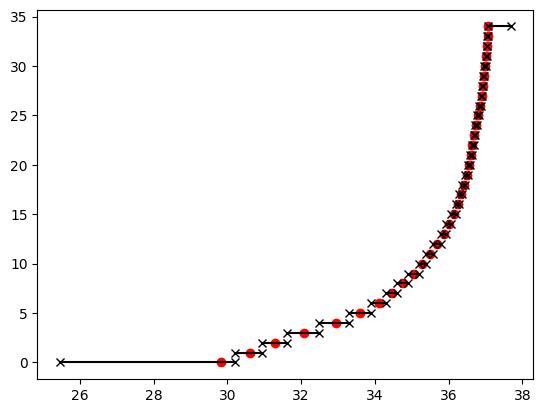

In [141]:
plt.plot(rho_sigma2_ref, np.arange(35), marker='o', color='r', ls='')
for zl in range(35):
    plt.plot([rho_sigma2_ref_edges[zl], rho_sigma2_ref_edges[zl+1]], [zl,zl], marker='x', color='k', ls='-')

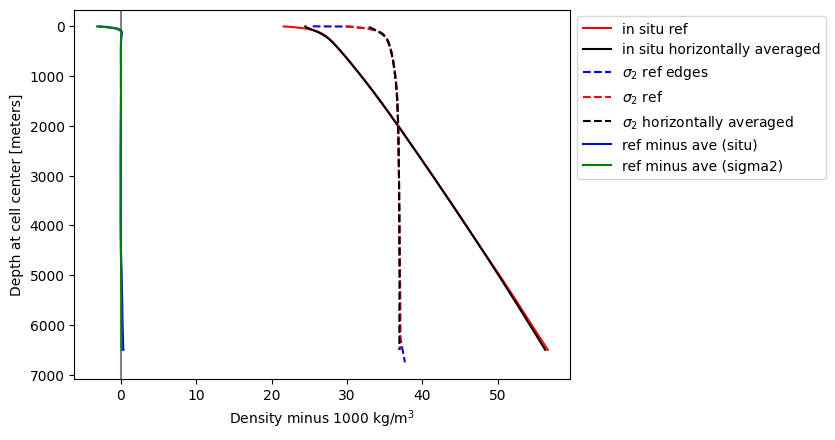

In [142]:
rho_in_situ_ave = (((rho_in_situ) * dV).sum(['xh','yh']) / (dV).sum(['xh','yh']))
rho_sigma2_ave = (((rho_sigma2) * dV).sum(['xh','yh']) / (dV).sum(['xh','yh']))

(rho_in_situ_ref-1000).plot(label='in situ ref', color='r', y='zl')
(rho_in_situ_ave-1000).plot(label='in situ horizontally averaged', color='k', y='zl')

(rho_sigma2_ref_edges).plot(label='$\sigma_2$ ref edges', color='b', y='z_i', ls='--')
(rho_sigma2_ref).plot(label='$\sigma_2$ ref', color='r', y='zl', ls='--')
(rho_sigma2_ave).plot(label='$\sigma_2$ horizontally averaged', color='k', y='zl', ls='--')


(rho_in_situ_ref-rho_in_situ_ave).plot(label='ref minus ave (situ)', color='b', y='zl')
(rho_sigma2_ref-rho_sigma2_ave).plot(label='ref minus ave (sigma2)', color='g', y='zl')
plt.gca().invert_yaxis()
plt.xlabel('Density minus 1000 kg/m$^3$')
plt.title('')
plt.axvline(x=0,color='gray', zorder=-1)

plt.legend(bbox_to_anchor=(1,1))

In [143]:
g = 9.8
z = - rho_in_situ.zl # z should be upward
APE = ((rho_in_situ-rho_in_situ_ref) * 9.8 * z * dV).sum('zl')

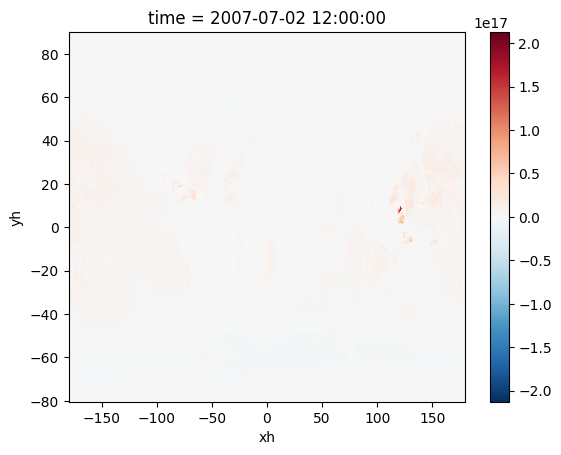

In [144]:
APE.plot()

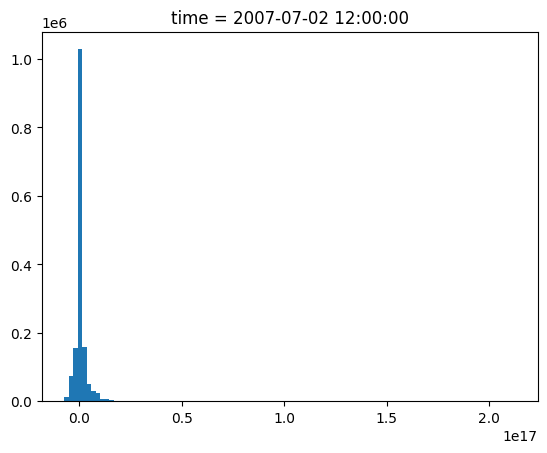

In [145]:
APE.plot.hist(bins=100);

In [146]:
# Computing total value in Joules
APE.sum()

<xarray.DataArray ()> Size: 8B
array(8.83962108e+20)
Coordinates:
    time     object 8B 2007-07-02 12:00:00

# Positive definite APE
To compute it, we need to know the vertical displacement of the fluid particles from the reference profile 
(Verdiere 2018)

Text(0.5, 1.0, 'Visual representation of displacements')

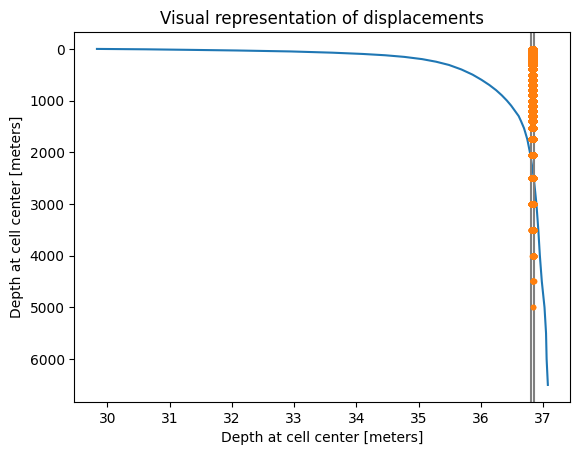

In [147]:
zl = 25
idx = np.logical_and(rho_sigma2_ref[zl] < rho_sigma2, rho_sigma2 < rho_sigma2_ref[zl+1])

x = xr.where(idx, rho_sigma2, np.nan)
y = xr.where(idx, rho_sigma2.zl, np.nan)

y = y.values.ravel()
y = y[~np.isnan(y)]

x = x.values.ravel()
x = x[~np.isnan(x)]


rho_sigma2_ref.plot(y='zl')
plt.gca().invert_yaxis()
plt.axvline(x=rho_sigma2_ref[zl], color='gray')
plt.axvline(x=rho_sigma2_ref[zl+1], color='gray')
plt.plot(x,y,'.',ls='')
plt.title('Visual representation of displacements')

In [148]:
reference_height = xr.DataArray(rho_sigma2_ref.zl, dims=['sigma2'], coords={'sigma2': rho_sigma2_ref.values})

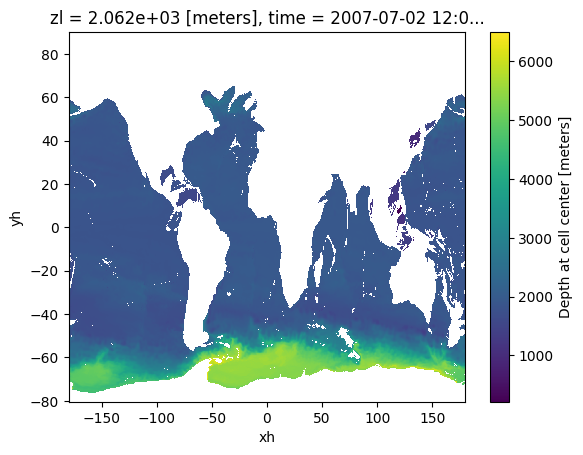

In [149]:
reference_height.interp(sigma2=rho_sigma2).isel(zl=25).plot()

In [150]:
# This algorithm appeared to be not convenient. We try another one.

# APE of interfaces displacement (failed)
Algorithm:
* Compute density on the interfaces by linear interpolation
* Compute reference height on interfaces
* Compute dispacements (zi - reference height)
* Compute the density jump on the interface. The density jump should correspond to the vertical increment (dz). But what to use, reference density or local one? Following code of MOM6, it seems that reference density is better.

This algorithm failed when I tried to define density jump. We consider another one below

# APE of interfaces displacement
Algorithm:
* Set reference heights a priori. It is already done in the sorting algorithm by setting binning intervals. So, reference height of interfaces will be simply zi:
* The density levels should be considered in-situ densities in sorted profile
* I need to assign every grid point to one of bins of the sorted profile.
* Then, if I have two vertically adjacent grid points classified to different bins, then I have an interface in position z_i. In that case the interface displacement will have only a discrete number of possible values.

In [151]:
layer = T * 0 # Here it is important to introduce NaNs so we do not count land as zero
rho_sigma2_remapped = T * 0
for zl in range(0,len(T.zl)):
    idx = np.logical_and(rho_sigma2 <= rho_sigma2_ref_edges[zl+1], rho_sigma2 > rho_sigma2_ref_edges[zl])
    layer += + xr.where(idx, zl, 0)
    rho_sigma2_remapped += + xr.where(idx, rho_sigma2_ref[zl], 0)

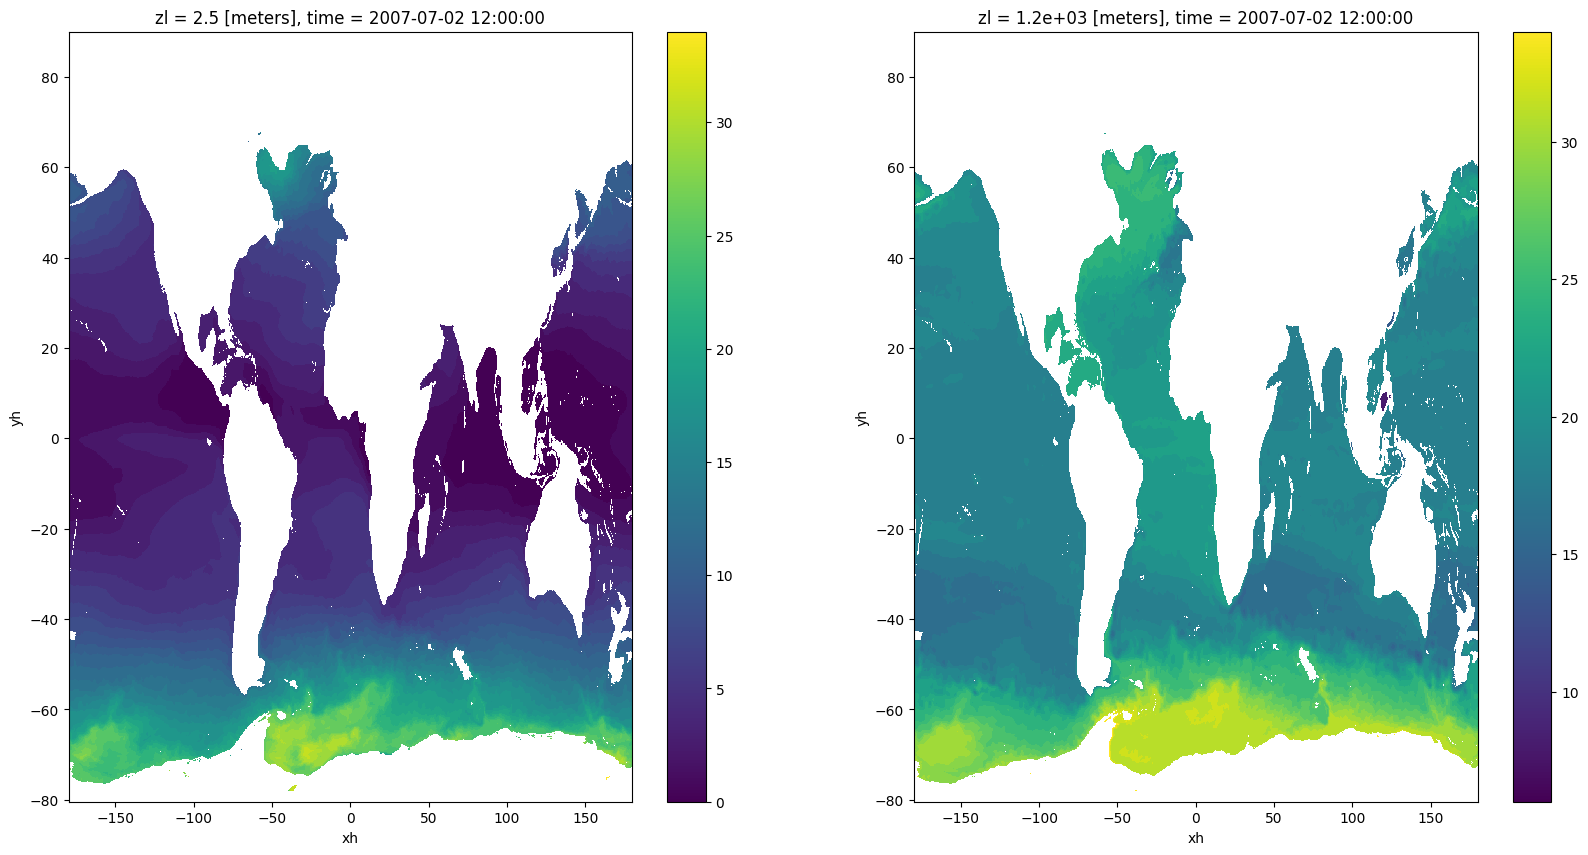

In [152]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
layer.isel(zl=0).plot()

plt.subplot(1,2,2)
layer.isel(zl=20).plot()

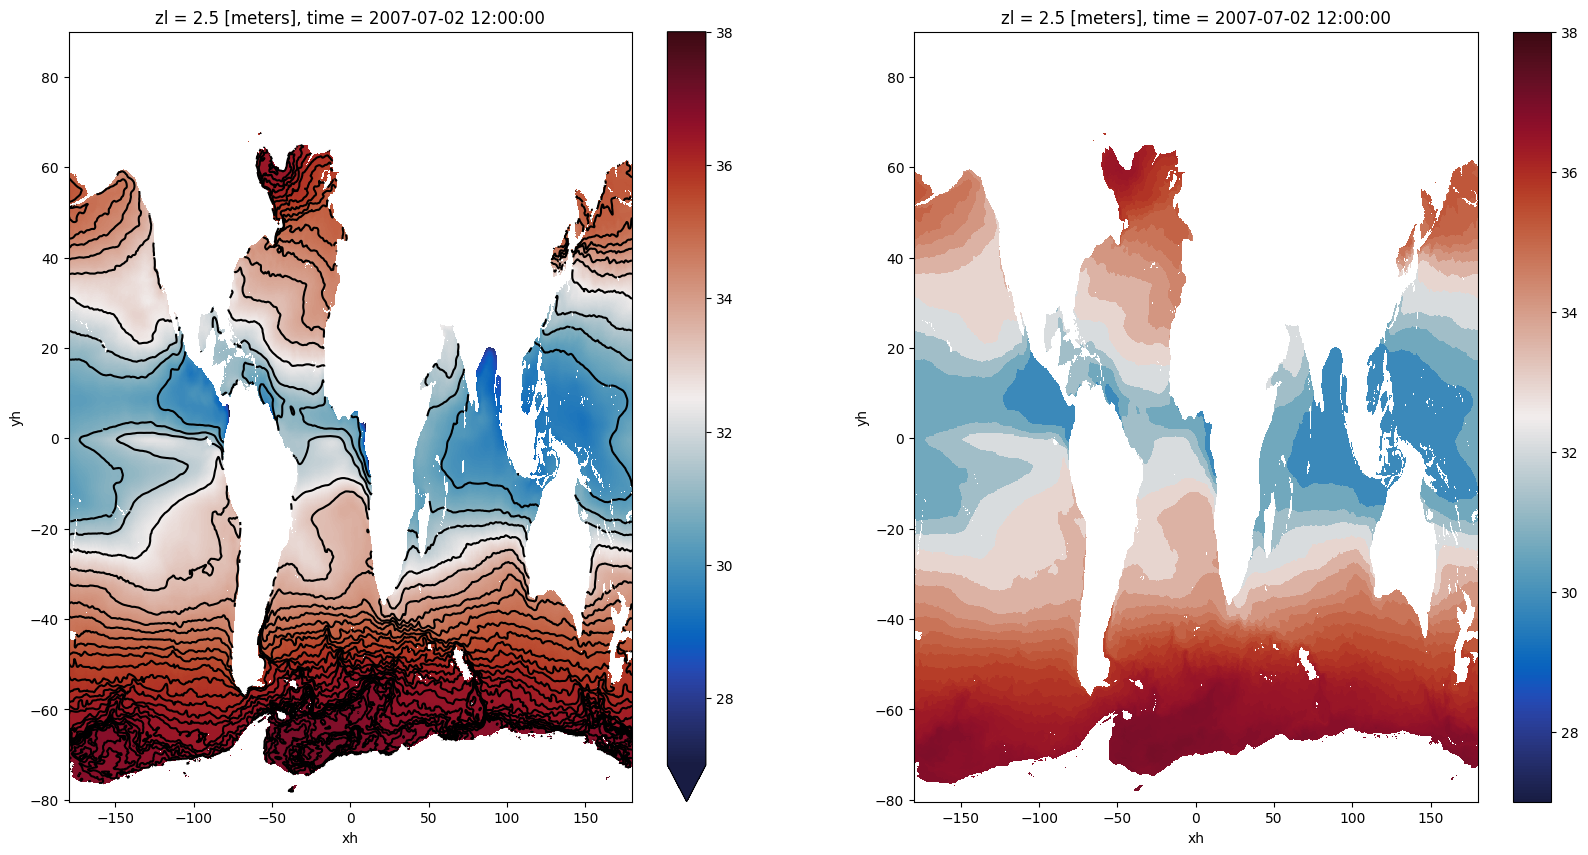

In [155]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
rho_sigma2.isel(zl=0).plot(vmin=27,vmax=38, cmap=cmocean.cm.balance)
rho_sigma2.isel(zl=0).plot.contour(levels=rho_sigma2_ref_edges, colors='k')

plt.subplot(1,2,2)
rho_sigma2_remapped.isel(zl=0).plot(vmin=27, vmax=38, cmap=cmocean.cm.balance)

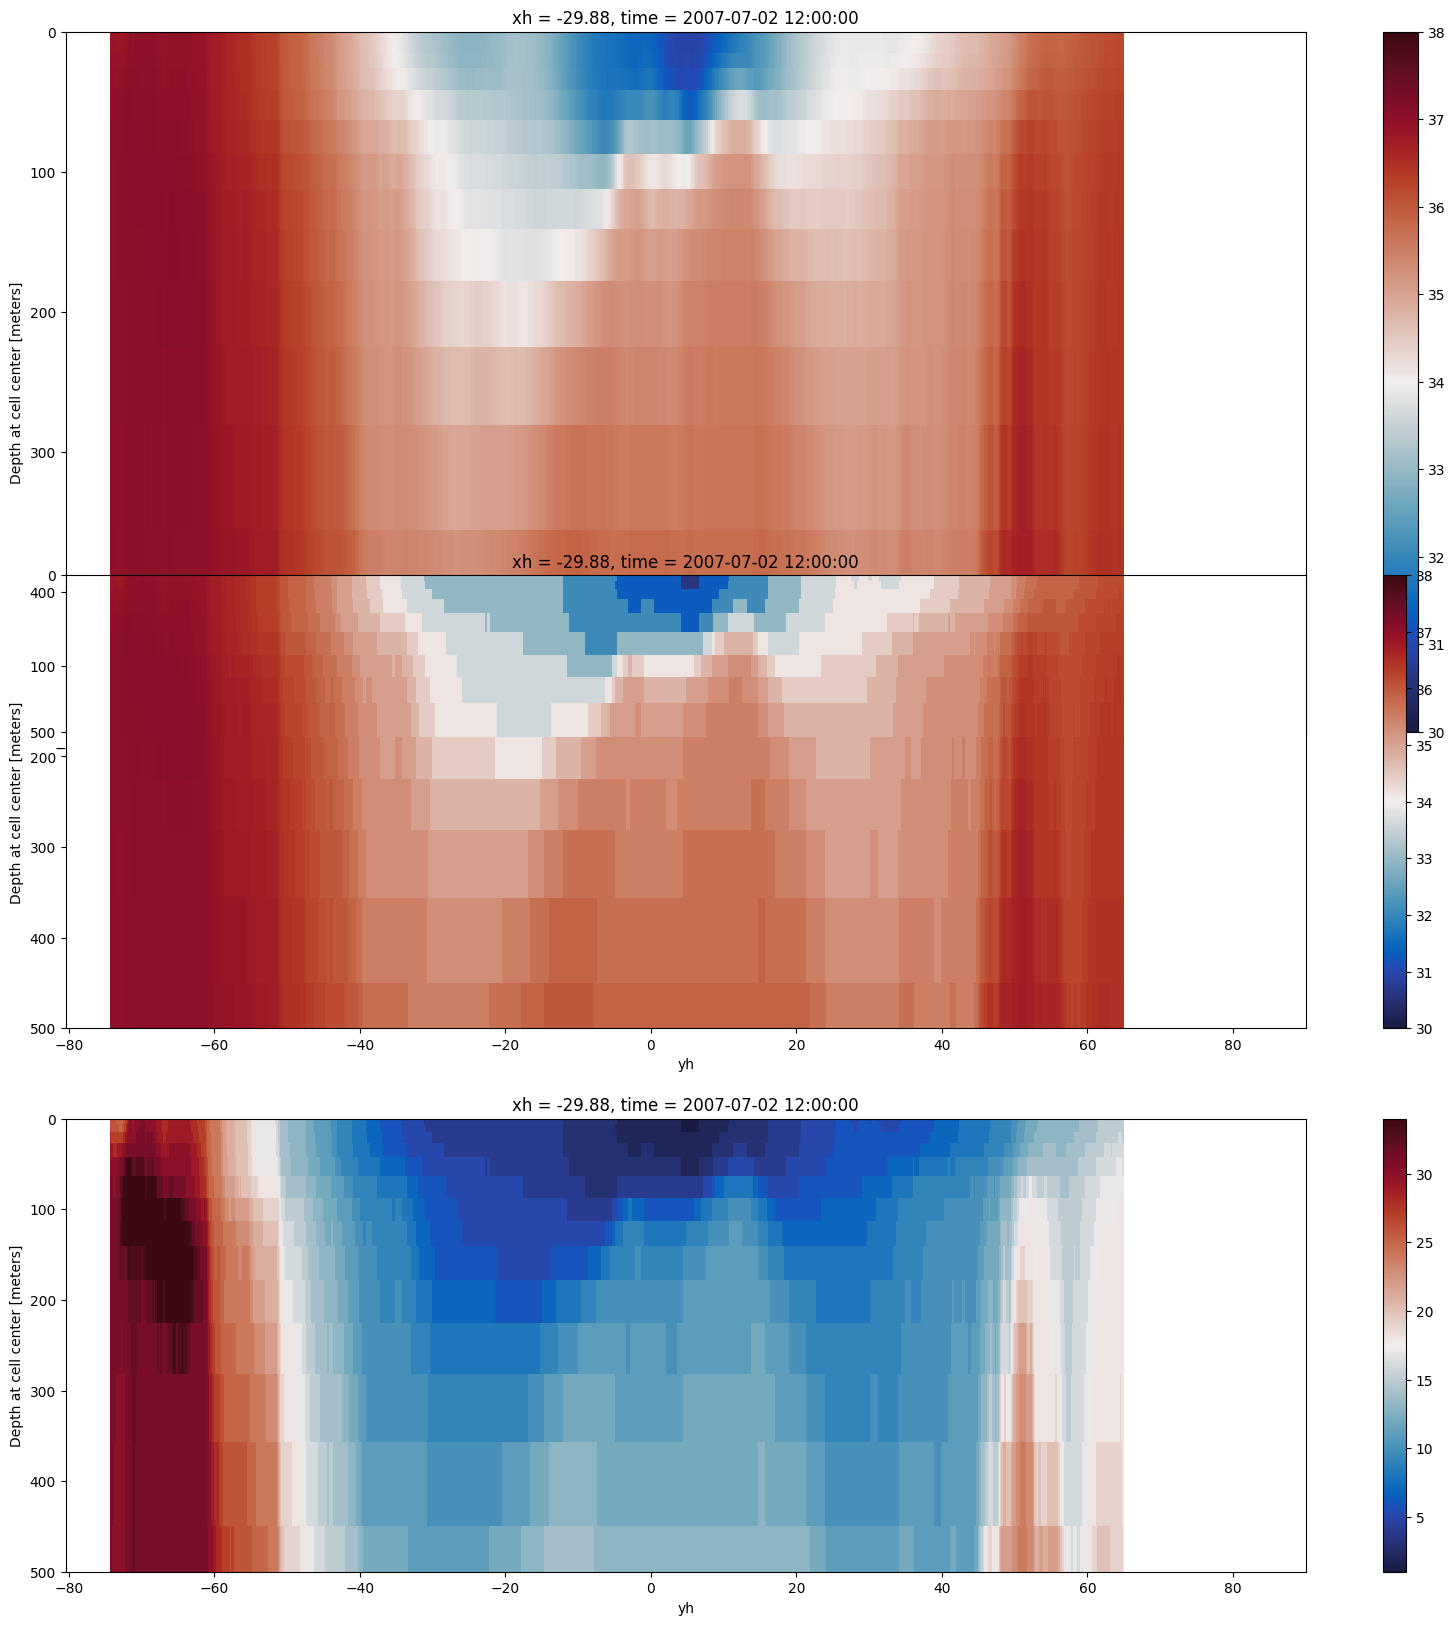

In [156]:
plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
rho_sigma2.sel(xh=-30, method='nearest').plot(vmin=30,vmax=38, cmap=cmocean.cm.balance)
#rho_sigma2.sel(xh=-30, method='nearest').plot.contour(levels=rho_sigma2_ref_edges, colors='k')
plt.ylim([0,500])
plt.gca().invert_yaxis()

plt.subplot(3,1,2)
rho_sigma2_remapped.sel(xh=-30, method='nearest').plot(vmin=30,vmax=38, cmap=cmocean.cm.balance)
plt.ylim([0,500])
plt.gca().invert_yaxis()

plt.subplot(3,1,3)
layer.sel(xh=-30, method='nearest').plot(cmap=cmocean.cm.balance)
plt.ylim([0,500])
plt.gca().invert_yaxis()


In [157]:
np.unique(layer.values.ravel())

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., nan])

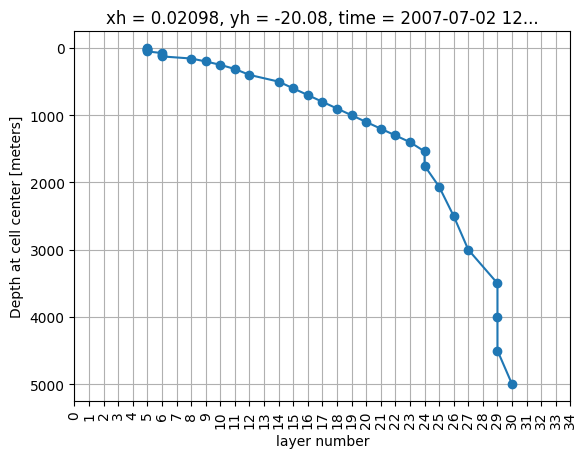

In [158]:
layer.sel(xh=0, yh=-20, method='nearest').plot(y='zl', marker='o')
plt.gca().invert_yaxis()
plt.xticks(np.arange(0,35), rotation=90);
plt.xlabel('layer number')
plt.grid()

In [159]:
layer.sel(xh=0, yh=-20, method='nearest')

<xarray.DataArray (zl: 35)> Size: 280B
array([ 5.,  5.,  5.,  5.,  5.,  6.,  6.,  6.,  8.,  9., 10., 11., 12.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 24., 25.,
       26., 27., 29., 29., 29., 30., nan, nan, nan])
Coordinates:
    xh       float64 8B 0.02098
    yh       float64 8B -20.08
  * zl       (zl) float64 280B 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
    time     object 8B 2007-07-02 12:00:00

# Finding interface position
* By convention, we do not extend our layers over topography. Instead, we allow only limited amount of layers to be present in every water column
* We not gonna use layer information. Instead, we will try to rewrite a code which used to compute layer, to compute interfaces.

In [160]:
def compute_interfaces(rho, edges):
    '''
    rho is 3D array zl, yh, xh
    edges is 1D array of z_i

    The algorithm returns depth of each edge as a function of horizontal coordiante:
    interfaces array of size z_i, yh, xh

    The algorithm is based on the:
    * Using density rho as a vertical coordinate. 
    * It is possible only if the density is a monotonic function of depth.
    * Density also should be monotonic to make sure that APE is positive (which depends on rho_i - rho_i+1)
    * So we ensure monotonicity by preprocessing density
    * In this case, there is an inverse function
    * The inverse function is interpolated linearly to compute the interfaces
    '''

    zl_depth = rho.zl.values
    rho_monotonic = np.sort(rho.values, axis=0)
    
    z_i, yh, xh = len(edges), len(rho.yh), len(rho.xh)
    interfaces = np.zeros((z_i,yh,xh)) * np.nan

    for j in range(yh):
        for i in range(xh):
            # We compute only internal interfaces
            # edges are densities
            # right and left = nan means that if interface does not fit to the water column, we set it to nan
            interfaces[1:-1,j,i] = np.interp(edges[1:-1], rho_monotonic[:,j,i], zl_depth, right=np.nan, left=np.nan)
    return xr.DataArray(interfaces, dims=['z_i','yh','xh'], coords={'z_i':edges.z_i, 'yh': rho.yh, 'xh': rho.xh})

In [161]:
%time interfaces = compute_interfaces(rho_sigma2, rho_sigma2_ref_edges)

CPU times: user 2min 4s, sys: 395 ms, total: 2min 5s
Wall time: 2min 5s


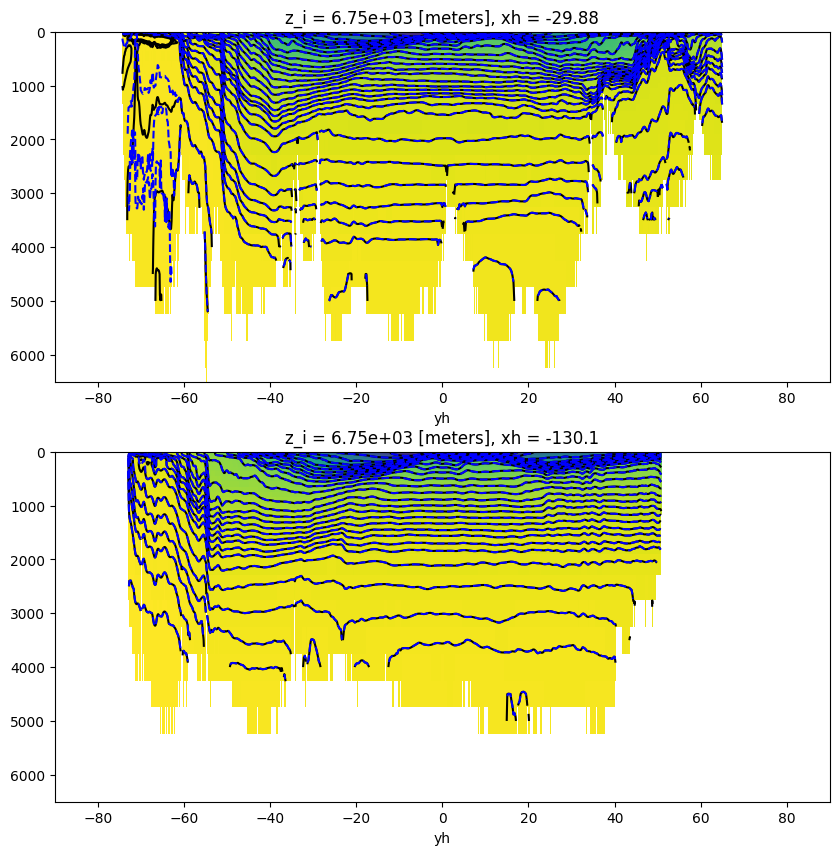

In [162]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
rho_sigma2.sel(xh=-30,method='nearest').plot(add_colorbar=False)
rho_sigma2.sel(xh=-30,method='nearest').plot.contour(colors='k', levels=rho_sigma2_ref_edges)

for z_i in range(36):
    interfaces[z_i].sel(xh=-30,method='nearest').plot(color='b', ls='--')
plt.xlim([-90,90])
plt.ylim([0,6500])
plt.gca().invert_yaxis()

plt.subplot(2,1,2)
rho_sigma2.sel(xh=-130,method='nearest').plot(add_colorbar=False)
rho_sigma2.sel(xh=-130,method='nearest').plot.contour(colors='k', levels=rho_sigma2_ref_edges)

for z_i in range(36):
    interfaces[z_i].sel(xh=-130,method='nearest').plot(color='b', ls='--')
plt.xlim([-90,90])
plt.ylim([0,6500])
plt.gca().invert_yaxis()

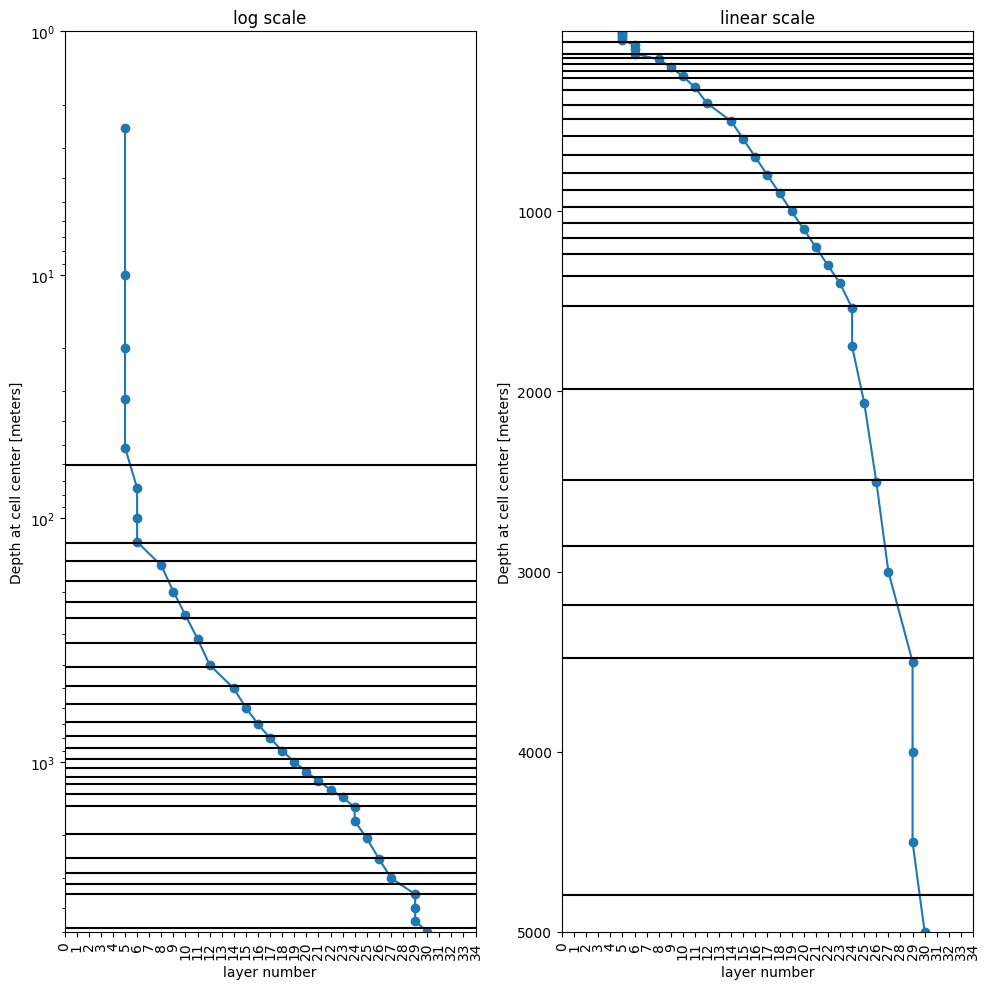

In [163]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
layer.sel(xh=0, yh=-20, method='nearest').plot(y='zl', marker='o')
for z_i in range(36):
    plt.axhline(y=interfaces[z_i].sel(xh=0, yh=-20, method='nearest'), color='k')
plt.ylim([1,5000])
plt.yscale('log')
plt.gca().invert_yaxis()
plt.xticks(np.arange(0,35), rotation=90);
plt.xlabel('layer number')
plt.title('log scale')

plt.subplot(1,2,2)
layer.sel(xh=0, yh=-20, method='nearest').plot(y='zl', marker='o')
for z_i in range(36):
    plt.axhline(y=interfaces[z_i].sel(xh=0, yh=-20, method='nearest'), color='k')
plt.ylim([1,5000])
plt.yscale('linear')
plt.gca().invert_yaxis()
plt.xticks(np.arange(0,35), rotation=90);
plt.xlabel('layer number')
plt.title('linear scale')
plt.tight_layout()

In [164]:
layer.sel(xh=0, yh=-20, method='nearest')

<xarray.DataArray (zl: 35)> Size: 280B
array([ 5.,  5.,  5.,  5.,  5.,  6.,  6.,  6.,  8.,  9., 10., 11., 12.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 24., 25.,
       26., 27., 29., 29., 29., 30., nan, nan, nan])
Coordinates:
    xh       float64 8B 0.02098
    yh       float64 8B -20.08
  * zl       (zl) float64 280B 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
    time     object 8B 2007-07-02 12:00:00

In [165]:
layer.zl

<xarray.DataArray 'zl' (zl: 35)> Size: 280B
array([2.5000e+00, 1.0000e+01, 2.0000e+01, 3.2500e+01, 5.1250e+01, 7.5000e+01,
       1.0000e+02, 1.2500e+02, 1.5625e+02, 2.0000e+02, 2.5000e+02, 3.1250e+02,
       4.0000e+02, 5.0000e+02, 6.0000e+02, 7.0000e+02, 8.0000e+02, 9.0000e+02,
       1.0000e+03, 1.1000e+03, 1.2000e+03, 1.3000e+03, 1.4000e+03, 1.5375e+03,
       1.7500e+03, 2.0625e+03, 2.5000e+03, 3.0000e+03, 3.5000e+03, 4.0000e+03,
       4.5000e+03, 5.0000e+03, 5.5000e+03, 6.0000e+03, 6.5000e+03])
Coordinates:
  * zl       (zl) float64 280B 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
    time     object 8B 2007-07-02 12:00:00
Attributes:
    long_name:       Depth at cell center
    units:           meters
    cartesian_axis:  Z
    positive:        down
    edges:           z_i

In [166]:
interfaces.sel(xh=0, yh=-20, method='nearest')

<xarray.DataArray (z_i: 36)> Size: 288B
array([          nan,           nan,           nan,           nan,
                 nan,           nan,   60.2613878 ,  126.07506406,
        150.10528058,  181.5575124 ,  219.96584304,  257.83981039,
        325.03771299,  408.28627563,  488.72867736,  579.85050509,
        685.16023388,  786.01421029,  881.87980472,  975.56724665,
       1062.92423085, 1150.52998519, 1234.66012054, 1360.73700432,
       1525.61942765, 1986.05846964, 2493.62067368, 2858.2898503 ,
       3187.24657595, 3478.38716199, 4797.08536176,           nan,
                 nan,           nan,           nan,           nan])
Coordinates:
  * z_i      (z_i) float64 288B 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
    yh       float64 8B -20.08
    xh       float64 8B 0.02098

# Computing APE using interfaces and reduced gravities
* Here we compute reduced gravity for reference profile of sigma2.
* We use reference profile because now our density is binned vertically.
* We use sigma2 because it contributes to buoyancy frequency which is a proxy of APE-related quantities
* Also, vertical derivative of sigma2 diminishes with depth, as it should be

In [167]:
rho_vals = rho_sigma2_ref.values
rho_vals

array([29.83183607, 30.6154199 , 31.28271624, 32.07200158, 32.9465741 ,
       33.6107705 , 34.10629906, 34.46374689, 34.76963507, 35.05890065,
       35.28242502, 35.48903345, 35.68940248, 35.86887957, 36.01182929,
       36.13768461, 36.24642052, 36.33858009, 36.41878639, 36.48917266,
       36.54906274, 36.60893926, 36.64744933, 36.69564735, 36.74808796,
       36.79983642, 36.85234388, 36.89456312, 36.92490993, 36.94982511,
       36.98124318, 37.02454723, 37.0490871 , 37.05836668, 37.07829461])

In [168]:
# Reduced gravity for internal interfaces
rho0 = 1035.
g = 9.8
g_prime = (rho_vals[1:] - rho_vals[:-1])/rho0 * g
# add zero values on surface and bottom interfaces, where we do not compute APE
g_prime = np.pad(g_prime,1,constant_values=np.nan)
g_prime = xr.DataArray(g_prime, dims='z_i', coords={'z_i': rho_sigma2_ref_edges.z_i})

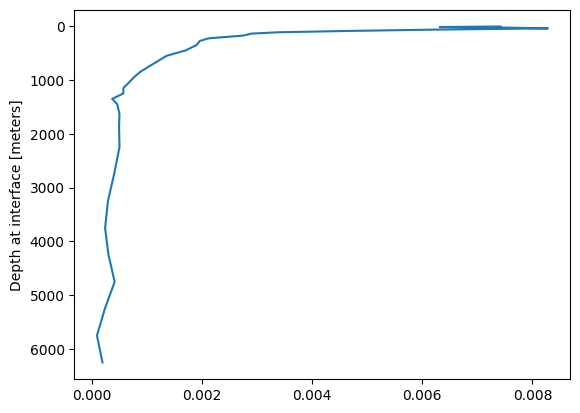

In [169]:
g_prime
g_prime.plot(y='z_i')
plt.gca().invert_yaxis()

In [170]:
# Note: interfaces.z_i is interfaces height in rest by construction!
APE = (0.5 * g_prime * (interfaces-interfaces.z_i)**2)*mask_nan[0]

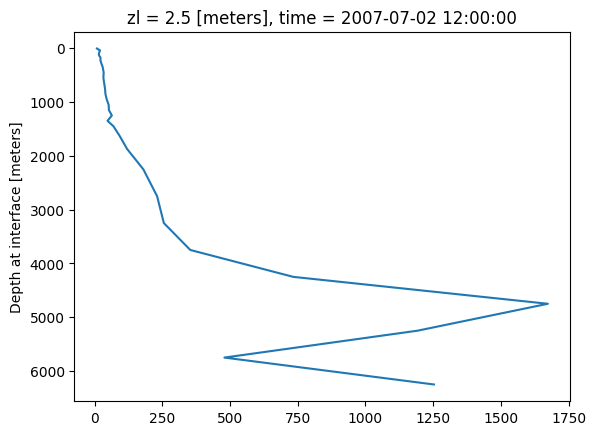

In [171]:
APE.mean(['xh','yh']).plot(y='z_i')
plt.gca().invert_yaxis()

In [172]:
%%time
# Coarsen to coarse 1x1 grid
coords = xr.Dataset()
coords['lon'] = param.geolon
coords['lat'] = param.geolat

regridder_1x1 = xe.Regridder(coords, xe.util.grid_global(1, 1), "nearest_s2d", periodic=True)
regridder_simple = xe.Regridder(coords, xe.util.grid_global(0.25, 0.25), "nearest_s2d", periodic=True)

CPU times: user 16.4 s, sys: 189 ms, total: 16.6 s
Wall time: 16.7 s


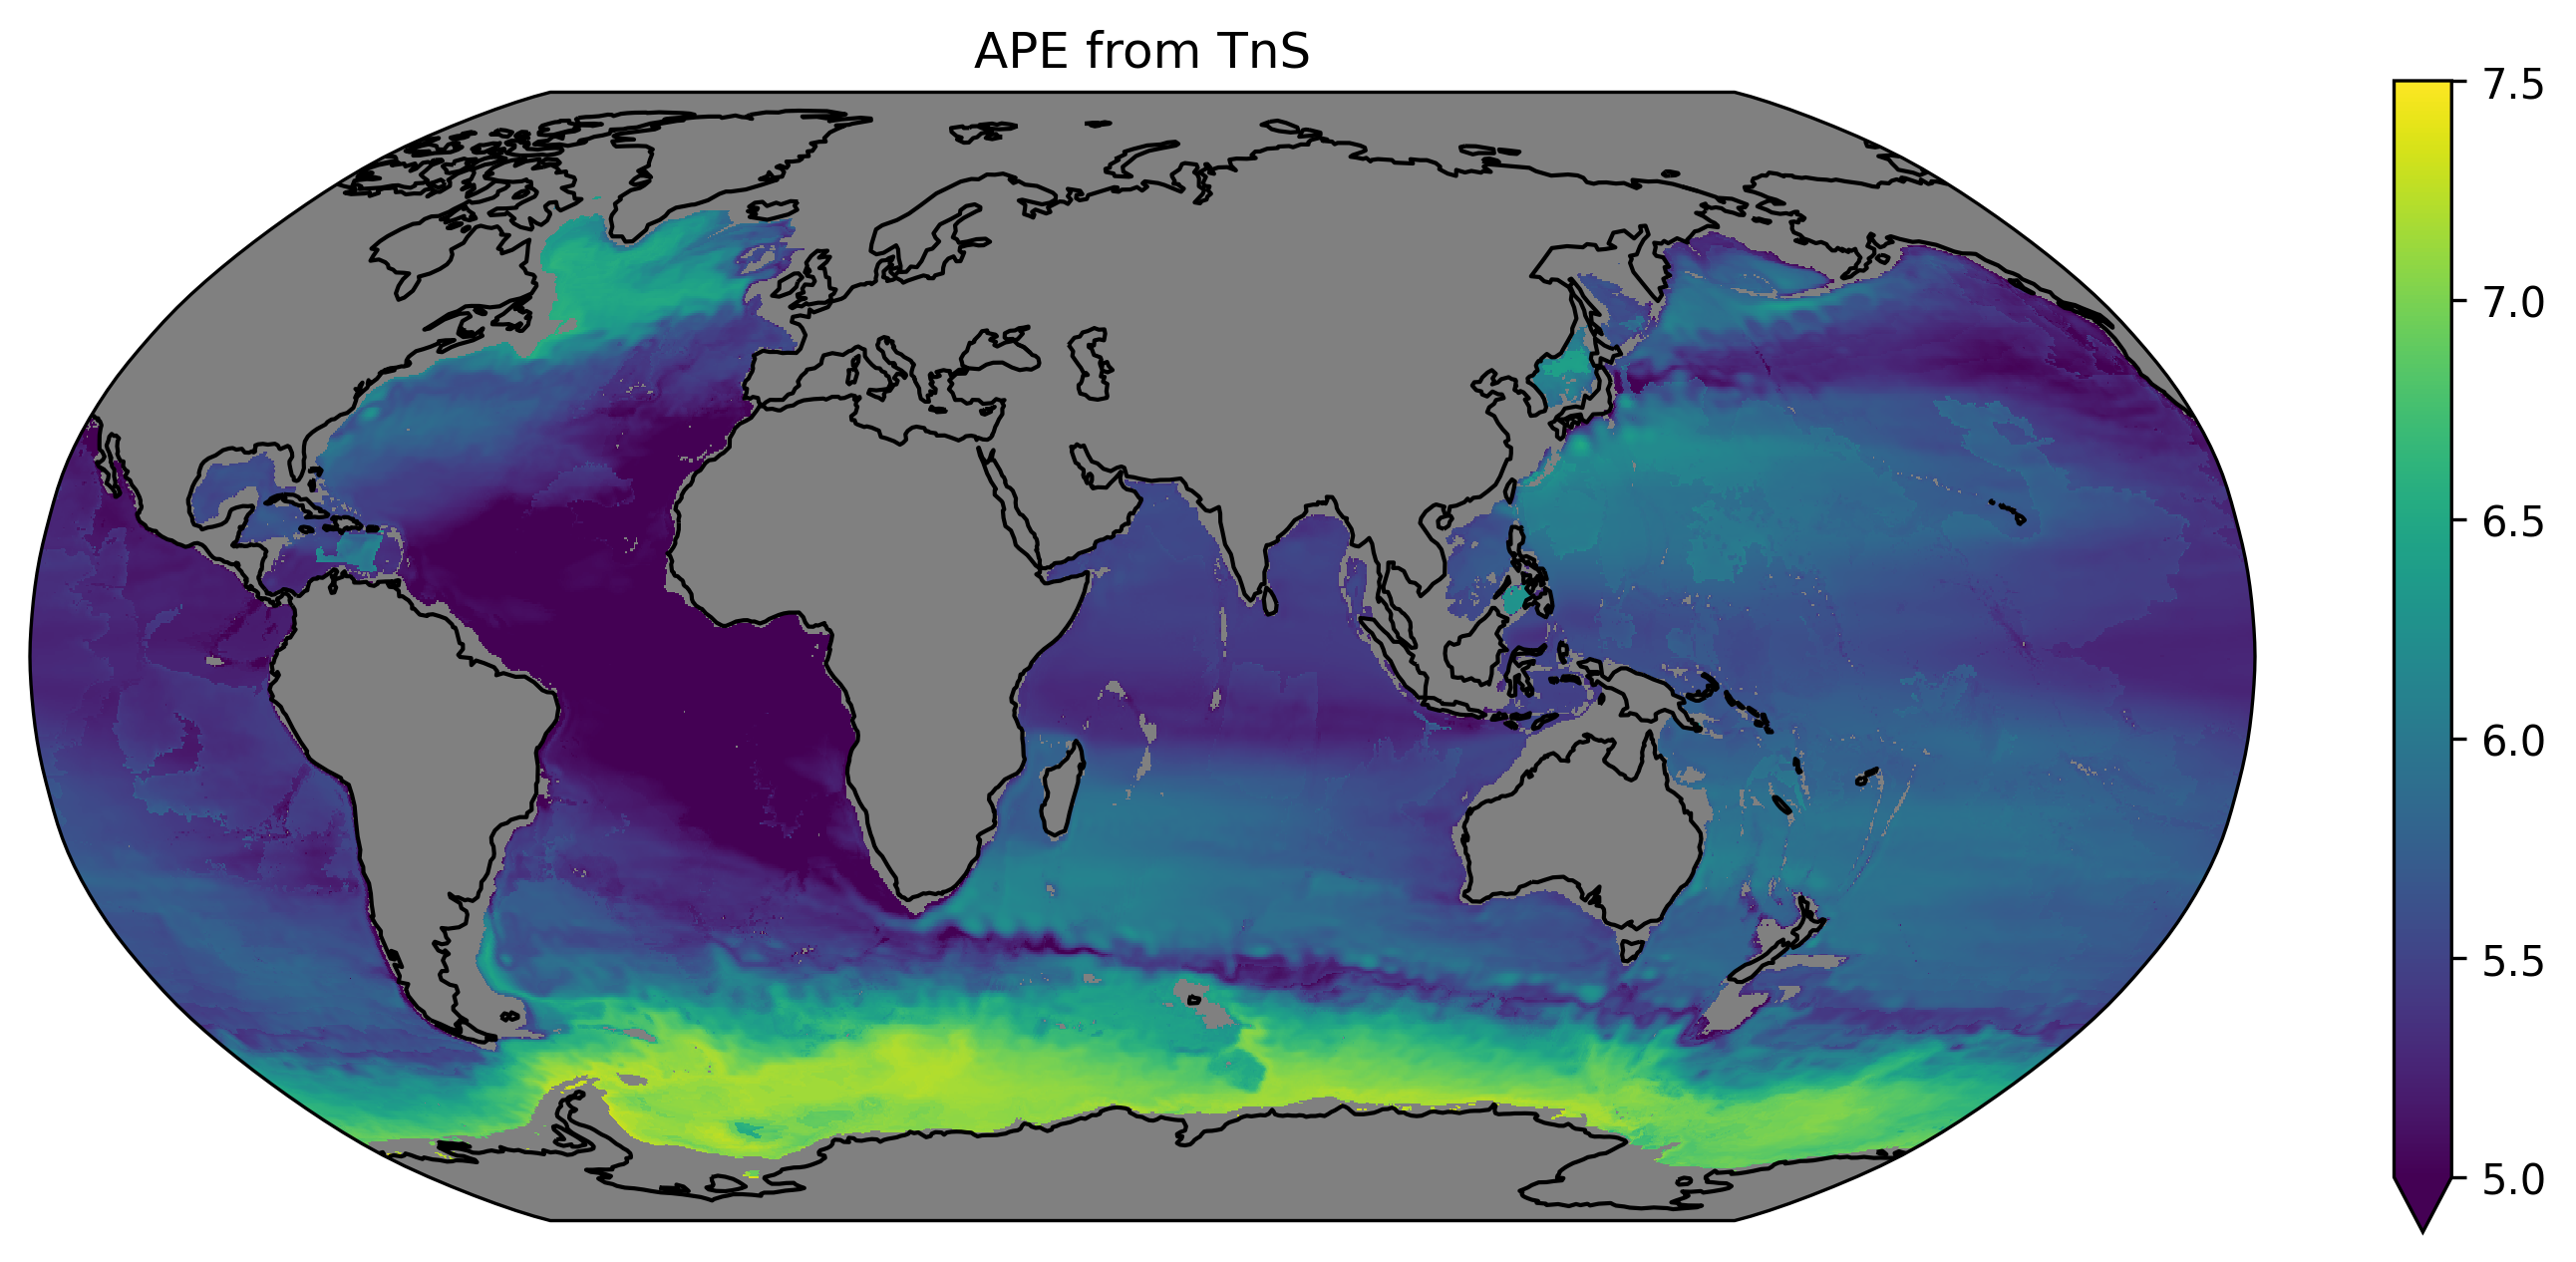

In [191]:
import cartopy

plt.figure(figsize=(12, 5), dpi=300)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=60))
regridder_simple(np.log10(rho0*APE.sum('z_i'))).plot(x='lon',y='lat', vmin=5,vmax=7.5, transform=ccrs.PlateCarree(),ax=ax)
#ax.add_feature(cartopy.feature.LAND, color='gray')
ax.coastlines()
plt.title('APE from TnS')
plt.gca().set_facecolor('gray')

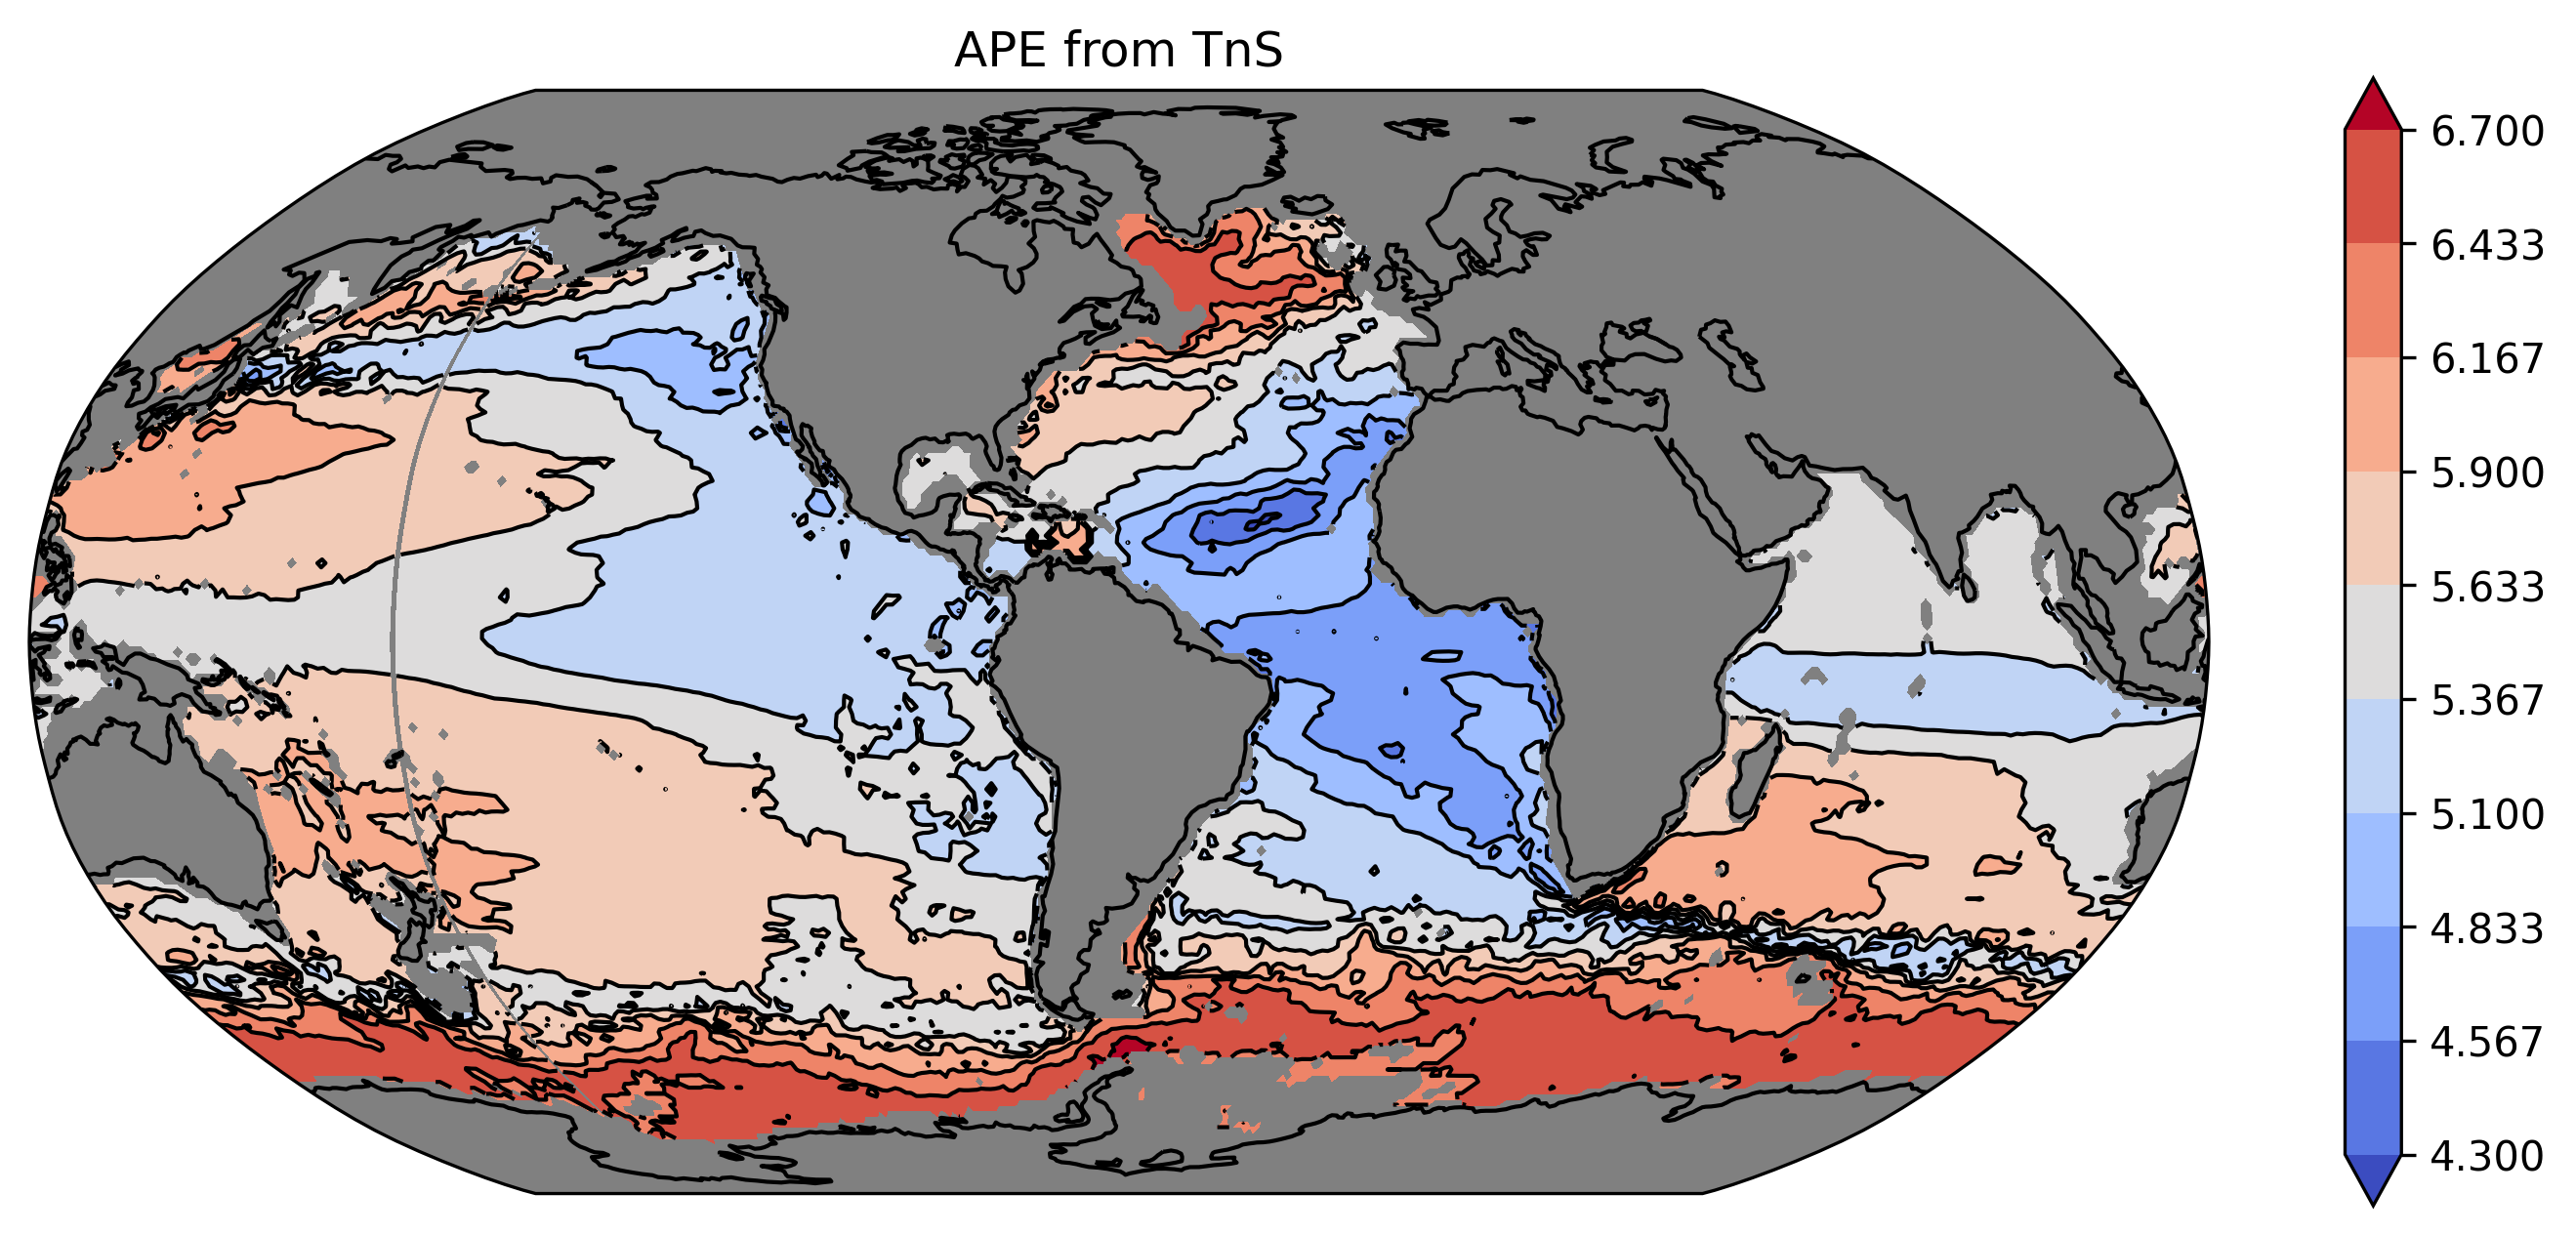

In [213]:
# Reproducing plot of ALAIN COLIN DE VERDIÈRE 2018
import cartopy

plt.figure(figsize=(12, 5), dpi=300)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-60))
regridder_1x1(np.log10(rho0*APE[0:28].sum('z_i'))).plot.contourf(x='lon',y='lat', vmin=4.3,vmax=6.7, transform=ccrs.PlateCarree(),ax=ax, levels=10, cmap=plt.cm.coolwarm)
regridder_1x1(np.log10(rho0*APE[0:28].sum('z_i'))).plot.contour(x='lon',y='lat', vmin=4.3,vmax=6.7, transform=ccrs.PlateCarree(),ax=ax, levels=10, colors='k', linewidths=1)
#ax.add_feature(cartopy.feature.LAND, color='gray')
ax.coastlines()
plt.title('APE from TnS')
plt.gca().set_facecolor('gray')

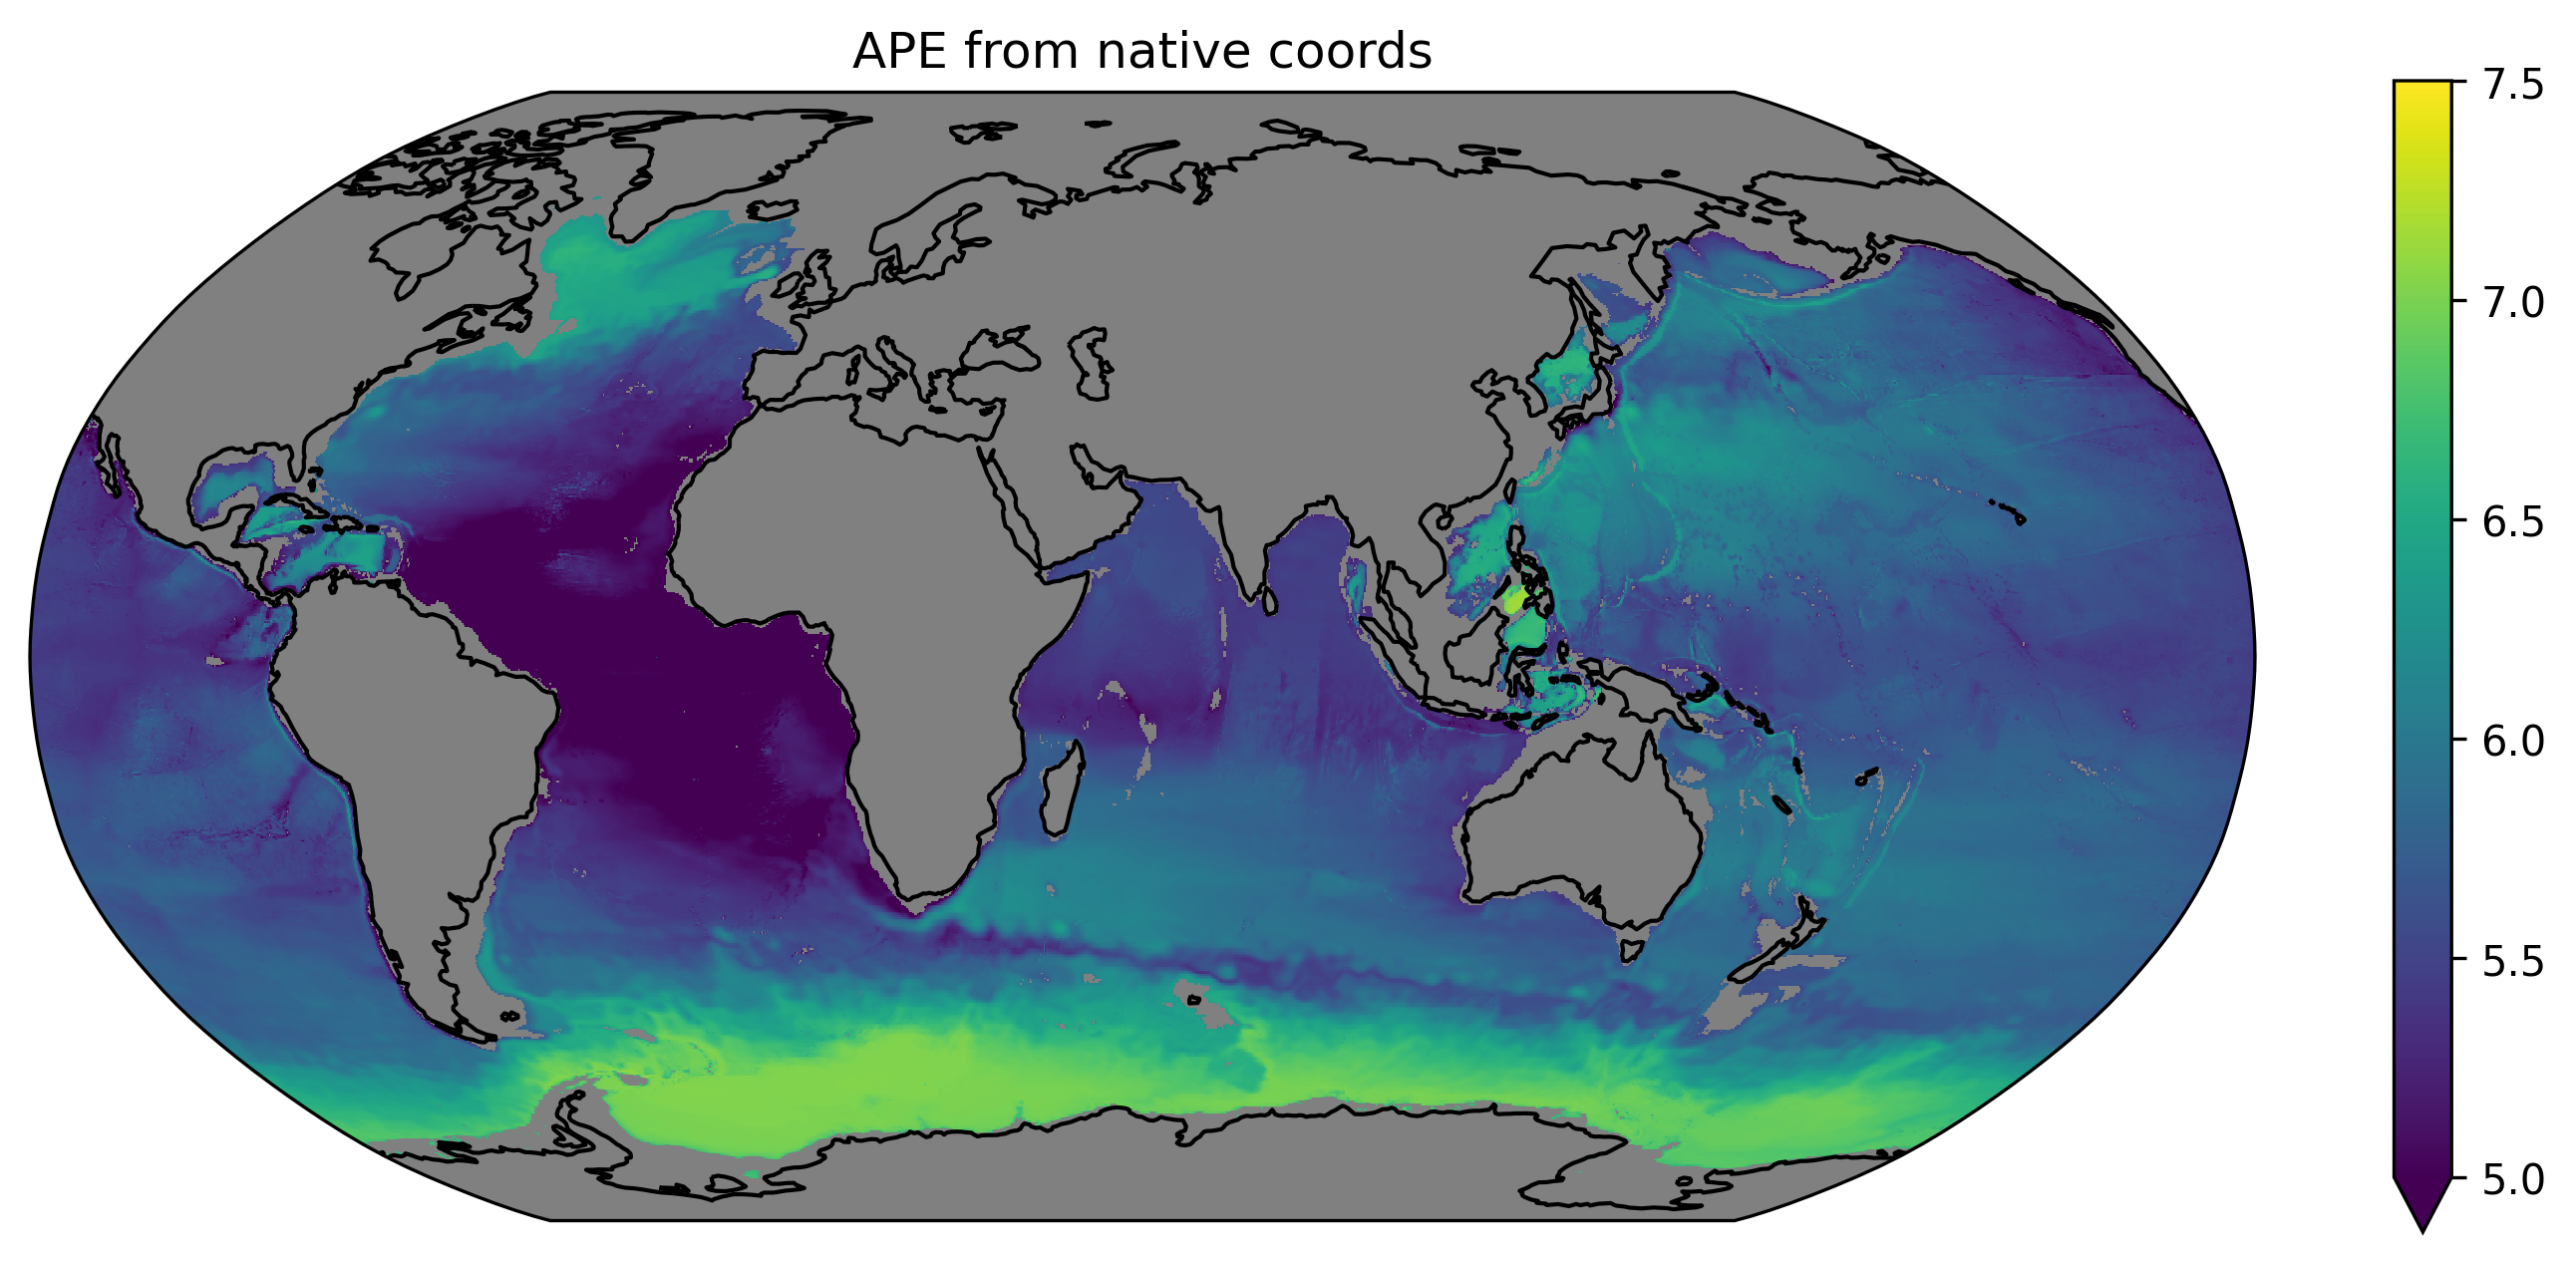

In [193]:
import cartopy

plt.figure(figsize=(12, 5), dpi=300)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=60))
regridder_simple(np.log10(rho0*APE_ctrl.sum('zi') * mask_simple)).plot(x='lon',y='lat', vmin=5,vmax=7.5, transform=ccrs.PlateCarree(),ax=ax)
#ax.add_feature(cartopy.feature.LAND, color='gray')
ax.coastlines()
plt.title('APE from native coords')
plt.gca().set_facecolor('gray')

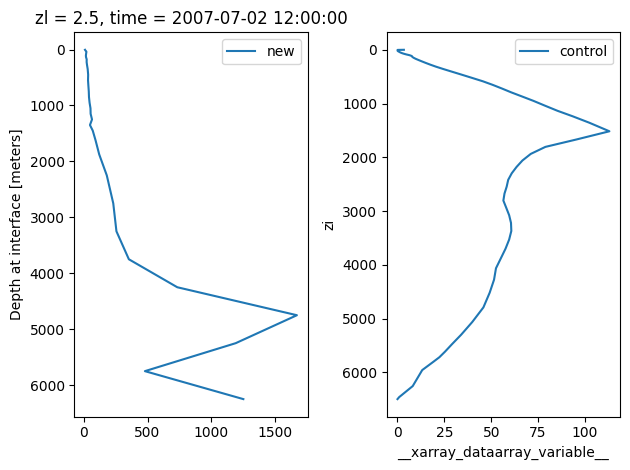

In [194]:
plt.subplot(1,2,1)
APE.mean(['xh','yh']).plot(y='z_i', label='new')
plt.gca().invert_yaxis()
plt.legend()

plt.subplot(1,2,2)
APE_ctrl.mean(['xh','yh']).plot(y='zi', label='control')
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()

In [66]:
APE_ctrl = xr.open_dataset('APE_ctrl.nc').__xarray_dataarray_variable__

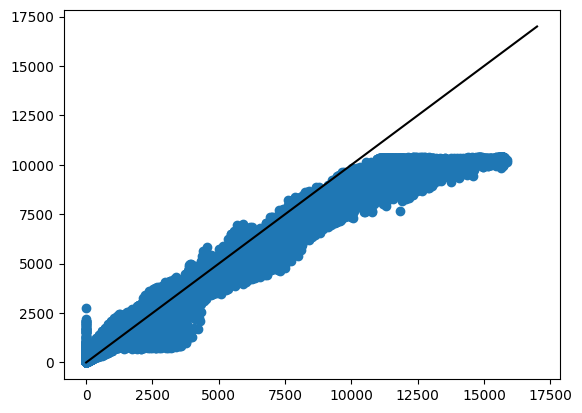

In [195]:
plt.scatter(select_Aghulas((APE.sum('z_i'))), select_Aghulas((APE_ctrl.sum('zi'))));
plt.plot([0,17000], [0,17000], color='k')

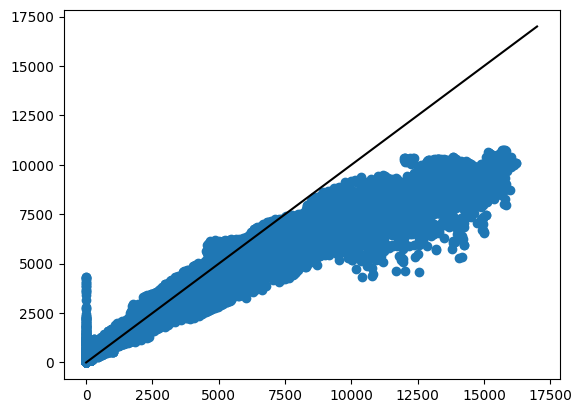

In [196]:
plt.scatter(select_Malvinas((APE.sum('z_i'))), select_Malvinas((APE_ctrl.sum('zi'))));
plt.plot([0,17000], [0,17000], color='k')

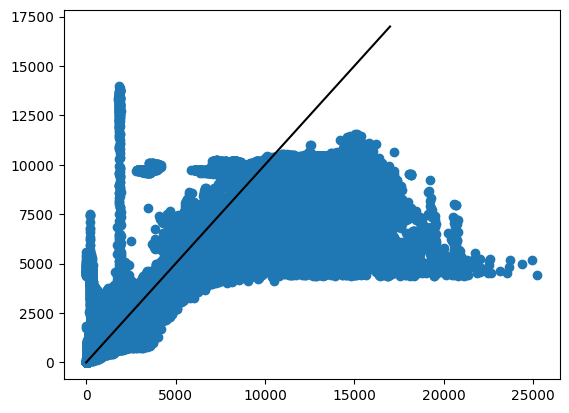

In [198]:
plt.scatter(((APE.sum('z_i'))), ((APE_ctrl*mask_simple)).sum('zi'));
plt.plot([0,17000], [0,17000], color='k')

In [199]:
(APE * param.areacello * rho0).sum()

<xarray.DataArray ()> Size: 8B
array(3.73795339e+20)
Coordinates:
    zl       float64 8B 2.5
    time     object 8B 2007-07-02 12:00:00

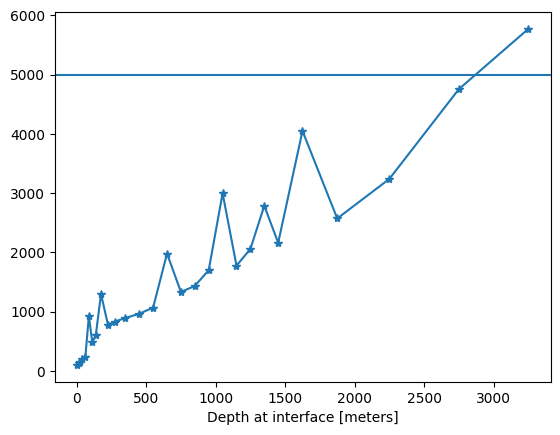

In [200]:
interfaces.max(['xh','yh'])[0:29].plot(ls='-', marker='*')
plt.axhline(y=5000)

In [201]:
# Choose maximum excursion of interfaces to be bounded by 5000m
# This value is very close to estimate C O L I N D E V E R D I È RE ET AL. 2018
(APE[0:28] * param.areacello * rho0).sum()

<xarray.DataArray ()> Size: 8B
array(2.10416855e+20)
Coordinates:
    zl       float64 8B 2.5
    time     object 8B 2007-07-02 12:00:00

In [216]:
APE.to_netcdf('APE-from-notebook.nc')

# APE from library function

In [3]:
from helpers.compute_APE import compute_APE, compute_mask

In [4]:
ds = CollectionOfExperiments.init_folder('/scratch/js15017/OM4_storage/CORE-AIF-runs', additional_subfolder='', Averaging_time=slice('1981', '2007'))

In [5]:
T = (ds['unparameterized'].ocean_annual_z.thetao.isel(time=-1)).compute().transpose('zl',...)
S = (ds['unparameterized'].ocean_annual_z.so.isel(time=-1)).compute().transpose('zl',...)

In [6]:
param = ds['unparameterized'].param

In [13]:
dz = ds['unparameterized'].dz
zi = ds['unparameterized'].ocean_annual_z.zi

In [7]:
mask = compute_mask(T, param)

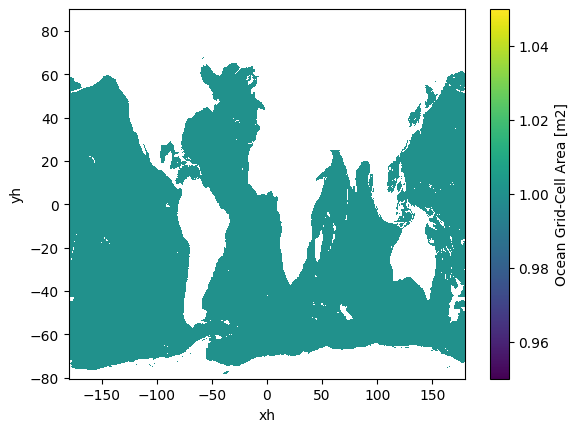

In [8]:
mask.plot()

In [18]:
%time APE = compute_APE(T*mask, S*mask, param.areacello, dz, zi)

CPU times: user 2min 17s, sys: 1.95 s, total: 2min 19s
Wall time: 2min 20s


In [27]:
APE_notebook = xr.open_dataset('APE-from-notebook.nc').__xarray_dataarray_variable__.rename({'z_i':'zi'})

In [31]:
np.abs(np.isnan(APE['APE']).astype('float32') - np.isnan(APE_notebook).astype('float32')).max()

<xarray.DataArray ()> Size: 4B
array(0., dtype=float32)
Coordinates:
    zl       float64 8B ...
    time     object 8B ...

In [32]:
np.abs(APE['APE'] - APE_notebook).max()

<xarray.DataArray ()> Size: 8B
array(0.)
Coordinates:
    zl       float64 8B ...
    time     object 8B ...